### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import logging
import sshtunnel
import os
import matplotlib.pyplot as plt
import pymysql
import paramiko
from dotenv import load_dotenv
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

/opt/anaconda3/lib/python3.12/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


### Setup for Database Connection

In [2]:
env_path=os.path.join('.keys', 'keys.env')

if os.path.exists(env_path):
    load_dotenv(env_path)


ssh_host = os.getenv('EC2_IP')
ssh_username = os.getenv('EC2_USER')
ssh_key = os.path.join('.keys','ecook-app-stage-live.pem')


db_host = os.getenv('RDS_HOST')
db_username = os.getenv('RDS_USER')
db_password = os.getenv('RDS_PASSWORD')
db_name = os.getenv('DB_NAME')


'''
with sshtunnel.SSHTunnelForwarder(
    (ssh_host, 22), 
    ssh_username=ssh_username, 
    ssh_pkey=ssh_key, 
    remote_bind_address=(db_host, 3306)
) as tunnel:
    print("Connecton Established", tunnel)
    
    db = pymysql.connect(
        host='127.0.0.1',
        user=db_username,
        passwd=db_password,
        db=db_name,
        port=tunnel.local_bind_port
    )
    with db.cursor() as cur:
        cur.execute("select * from tbl_accounts")
        for r in cur:
             print(r)
    db.close()
'''


def open_ssh_tunnel(verbose=False):
    if verbose:
        sshtunnel.DEFAULT_LOGLEVEL = logging.DEBUG
    global tunnel
    tunnel = sshtunnel.SSHTunnelForwarder(
        (ssh_host, 22),
        ssh_username = ssh_username,
        ssh_pkey = ssh_key,
        remote_bind_address=(db_host, 3306)
    )
    tunnel.start()


def mysql_connect():
    global connection 
    connection = pymysql.connect(
        host='localhost',
        user=db_username,
        passwd=db_password,
        db=db_name,
        port=tunnel.local_bind_port
    )


def run_query(sql):
    return pd.read_sql_query(sql, connection)

def mysql_disconnect():

    connection.close()

def close_ssh_tunnel():
    tunnel.close

In [3]:
open_ssh_tunnel()
mysql_connect()

### Query Data for Analysis

In [4]:
query = """
SELECT 
    u.unit_number, 
    u.calendar_date, 
    u.daily_power_consumption, 
    a.registration_date_utc 
FROM 
    tbl_daily_compiled_usage_data u
JOIN 
    tbl_accounts a 
    ON a.account_number = u.unit_number
WHERE 
    a.country = 'Bangladesh'
    AND u.daily_power_consumption IS NOT NULL
    AND a.registration_date_utc >= '2023-09-01'
    AND u.calendar_date >= '2023-09-01'
    AND a.account_status IN ('ENABLED', 'UNLOCKED');
    """

In [5]:
df = run_query(query)

In [7]:
df.head()

,unit_number,calendar_date,daily_power_consumption,registration_date_utc
0,134644111,2024-03-01,0.10,2024-02-28 18:00:00
1,134644111,2024-03-02,0.68,2024-02-28 18:00:00
2,134644111,2024-03-03,3.46,2024-02-28 18:00:00
3,134644111,2024-03-04,5.91,2024-02-28 18:00:00
4,134644111,2024-03-05,3.50,2024-02-28 18:00:00


### Data Pre Processing

In [8]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['registration_date_utc'] = pd.to_datetime(df['registration_date_utc'])

df['registration_date_utc'] = df['registration_date_utc'].dt.date

df['registration_date_utc'] = pd.to_datetime(df['registration_date_utc'])

In [9]:
df = df.sort_values(by=['unit_number', 'calendar_date'])

In [10]:
def fill_missing_days(group):
    reg_date = group['registration_date_utc'].iloc[0]
    
    full_days = pd.DataFrame({'days_since_onboarding': range(1, group['days_since_onboarding'].max() + 1)})
    full_days['unit_number'] = group['unit_number'].iloc[0]
    full_days['registration_date_utc'] = reg_date
    full_days['calendar_date'] = full_days['days_since_onboarding'].apply(lambda x: (reg_date + pd.Timedelta(days=x)).date())
    
    merged = pd.merge(full_days, group[['days_since_onboarding', 'daily_power_consumption']], 
                      on='days_since_onboarding', how='left')
    merged['daily_power_consumption'] = merged['daily_power_consumption'].fillna(0.0)
    return merged

In [11]:
df['days_since_onboarding'] = (df['calendar_date'] - df['registration_date_utc']).dt.days

In [12]:
df = df.groupby('unit_number', group_keys=False).apply(fill_missing_days).sort_values(['unit_number', 'days_since_onboarding'])

In [13]:
top_reg_date = df['registration_date_utc'].value_counts().idxmax()

largest_cohort = df[df['registration_date_utc'] == top_reg_date].copy()

df = largest_cohort[largest_cohort['days_since_onboarding'] >= 1].copy()

df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['registration_date_utc'] = pd.to_datetime(df['registration_date_utc'])

num_users = df['unit_number'].nunique()
print(f"Number of unique users in the largest cohort (registered on {top_reg_date.date()}): {num_users}")

Number of unique users in the largest cohort (registered on 2024-10-11): 123


In [14]:
df.head()

,days_since_onboarding,unit_number,registration_date_utc,calendar_date,daily_power_consumption
0,1,134449719,2024-10-11,2024-10-12,0.00
1,2,134449719,2024-10-11,2024-10-13,0.00
2,3,134449719,2024-10-11,2024-10-14,0.00
3,4,134449719,2024-10-11,2024-10-15,0.01
4,5,134449719,2024-10-11,2024-10-16,0.00


### Analysis

#### Usgae Bands

In [15]:
ZERO_USER = 0
VERY_LOW_USER = 0.5
LOW_USER = 1.5
MODERATE_USER = 2.0
HIGH_USER = 3.0

def classify_band(value):
    if value <= ZERO_USER:
        return 'Zero'
    elif value <= VERY_LOW_USER:
        return 'Very Low'
    elif value <= LOW_USER:
        return 'Low'
    elif value <= MODERATE_USER:
        return 'Moderate'
    elif value <= HIGH_USER:
        return 'High'
    else:
        return 'Very High'

df['usage_band'] = df['daily_power_consumption'].apply(classify_band)

In [16]:
band_counts = df.groupby(['days_since_onboarding', 'usage_band'])['unit_number'] \
                .nunique().unstack(fill_value=0)

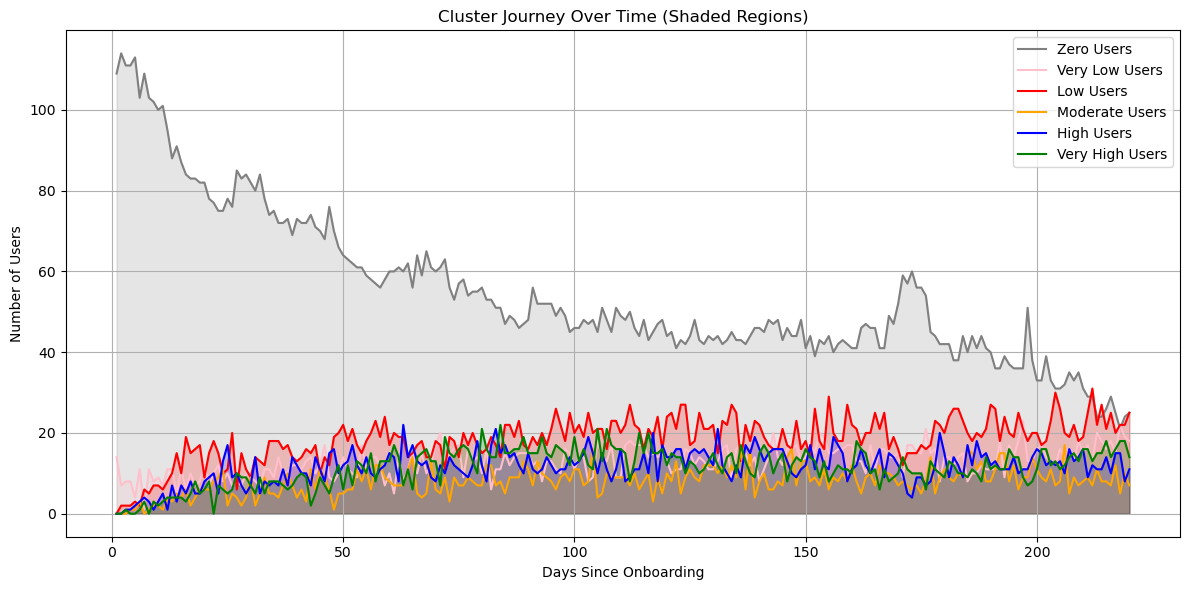

In [17]:
plt.figure(figsize=(12, 6))

for band, color in zip(['Zero','Very Low','Low','Moderate','High','Very High'], ['grey','pink','red','orange','blue','green']):
    if band in band_counts:
        plt.plot(band_counts.index, band_counts[band], label=f'{band} Users', color=color)
        plt.fill_between(band_counts.index, band_counts[band], alpha=0.2, color=color)

plt.xlabel('Days Since Onboarding')
plt.ylabel('Number of Users')
plt.title('Cluster Journey Over Time (Shaded Regions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Heat Map of User Over Time

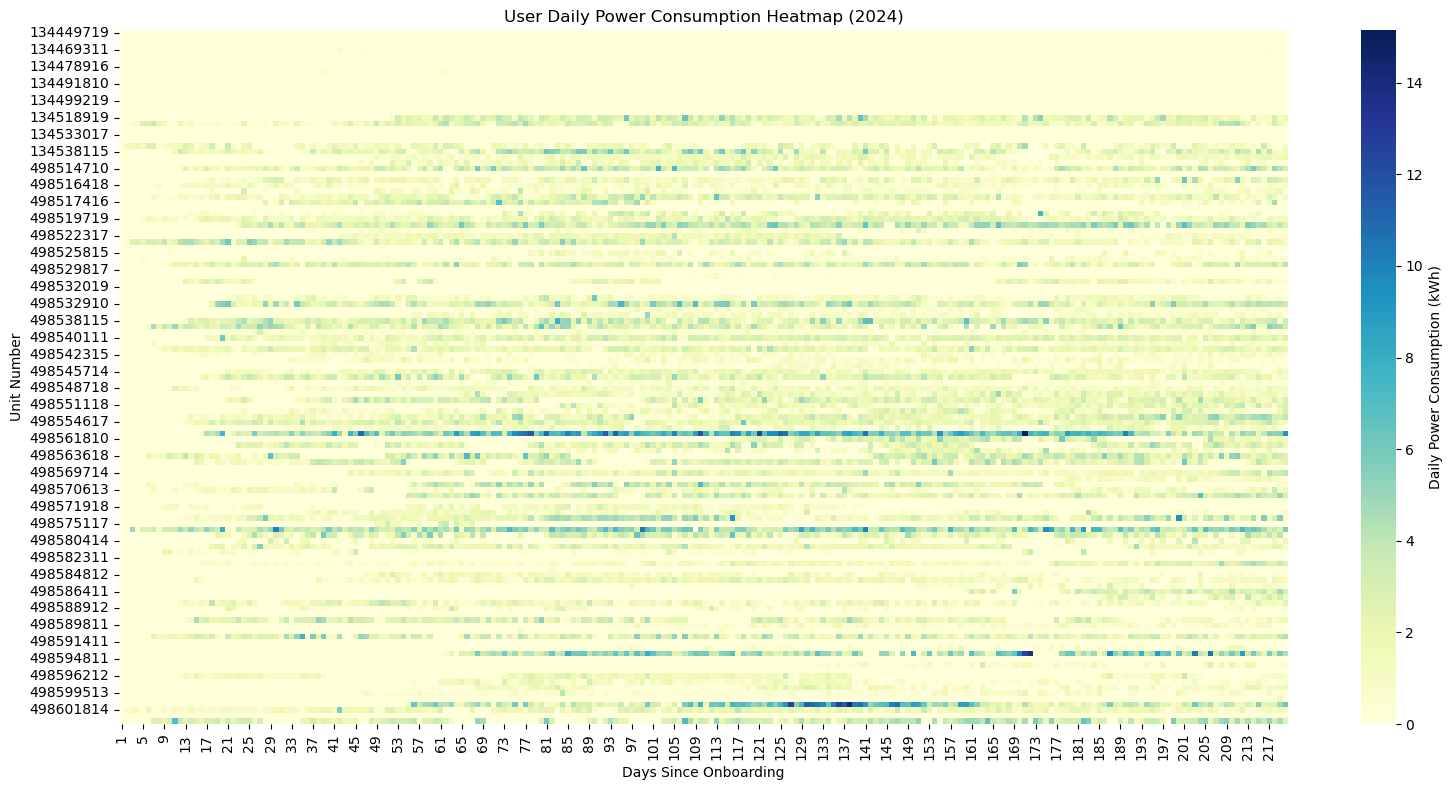

In [18]:
heatmap_data = df.pivot_table(index='unit_number', 
                               columns='days_since_onboarding', 
                               values='daily_power_consumption', 
                               fill_value=0.0)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Daily Power Consumption (kWh)'})
plt.title('User Daily Power Consumption Heatmap (2024)')
plt.xlabel('Days Since Onboarding')
plt.ylabel('Unit Number')
plt.tight_layout()
plt.show()

In [19]:
df.head()

,days_since_onboarding,unit_number,registration_date_utc,calendar_date,daily_power_consumption,usage_band
0,1,134449719,2024-10-11,2024-10-12,0.00,Zero
1,2,134449719,2024-10-11,2024-10-13,0.00,Zero
2,3,134449719,2024-10-11,2024-10-14,0.00,Zero
3,4,134449719,2024-10-11,2024-10-15,0.01,Very Low
4,5,134449719,2024-10-11,2024-10-16,0.00,Zero


In [26]:
def animate_timeline_cluster_by_days(unit_number):
    user_df = df[df['unit_number'] == unit_number].copy()

    day_behavior = user_df.groupby('days_since_onboarding')['daily_power_consumption'].agg(['mean', 'std']).reset_index()
    day_behavior = day_behavior.fillna(0)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(day_behavior[['mean', 'std']])

    kmeans = KMeans(n_clusters=3, random_state=42)
    day_behavior['cluster'] = kmeans.fit_predict(features_scaled)

    fig = px.scatter(
        day_behavior,
        x='mean',
        y='std',
        animation_frame=day_behavior['days_since_onboarding'].astype(str),
        color='cluster',
        text=day_behavior['days_since_onboarding'].astype(str),
        title=f"User {unit_number} - Cluster Journey Over Onboarding Timeline",
        labels={'mean': 'Average Daily Consumption (kWh)', 'std': 'Usage Variability (kWh)'},
        width=900,
        height=600
    )

    fig.update_traces(textposition='top center')
    fig.update_layout(
        xaxis=dict(title='Average Daily Consumption (kWh)'),
        yaxis=dict(title='Usage Variability (kWh)'),
        hovermode='closest',
        updatemenus=[{
            'buttons': [
                {'label': 'Play', 'method': 'animate', 'args': [None]},
                {'label': 'Pause', 'method': 'animate', 'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate', 'transition': {'duration': 0}}]}
            ],
            'type': 'buttons',
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }]
    )

    fig.show()

In [27]:
def user_journey_by_days(unit):
    user_df = df[df['unit_number'] == unit].copy()

    daily_stats = user_df.groupby('days_since_onboarding')['daily_power_consumption'] \
                         .agg(['mean', 'std', 'max', 'min']).reset_index()
    daily_stats = daily_stats.fillna(0)

    n_clusters = min(3, len(daily_stats))
    scaler = StandardScaler()
    scaled = scaler.fit_transform(daily_stats[['mean', 'std', 'max', 'min']])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    daily_stats['cluster'] = kmeans.fit_predict(scaled)

    centroids = daily_stats.groupby('cluster')['mean'].mean().sort_values().reset_index()
    labels = ['Low Users', 'Moderate Users', 'High Users'][:n_clusters]
    cluster_map = dict(zip(centroids['cluster'], labels))
    daily_stats['usage_level'] = daily_stats['cluster'].map(cluster_map)

    fig = px.line(
        daily_stats,
        x='days_since_onboarding',
        y='usage_level',
        markers=True,
        title=f'Cluster Journey of User {unit} by Days Since Onboarding'
    )

    fig.update_layout(
        yaxis_title='Cluster',
        xaxis_title='Days Since Onboarding',
        yaxis=dict(categoryorder='array', categoryarray=labels)
    )

    fig.show()

In [37]:
df.head()

,days_since_onboarding,unit_number,registration_date_utc,calendar_date,daily_power_consumption,usage_band
0,1,134449719,2024-10-11,2024-10-12,0.00,Low
1,2,134449719,2024-10-11,2024-10-13,0.00,Low
2,3,134449719,2024-10-11,2024-10-14,0.00,Low
3,4,134449719,2024-10-11,2024-10-15,0.01,Low
4,5,134449719,2024-10-11,2024-10-16,0.00,Low


In [36]:
animate_timeline_cluster_by_days(498605112)

In [39]:
user_journey_by_days(498605112)

#### First Transition

In [31]:
# first_transition = []

# for unit in df['unit_number'].unique():
#     user_df = df[df['unit_number'] == unit].copy()

#     if user_df['days_since_onboarding'].nunique() < 3:
#         continue

#     daily_stats = user_df.groupby('days_since_onboarding')['daily_power_consumption'] \
#                          .agg(['mean', 'std', 'max', 'min']).reset_index()
#     daily_stats = daily_stats.fillna(0)

#     n_clusters = min(3, len(daily_stats))
#     scaler = StandardScaler()
#     scaled = scaler.fit_transform(daily_stats[['mean', 'std', 'max', 'min']])
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     daily_stats['cluster'] = kmeans.fit_predict(scaled)

#     centroids = daily_stats.groupby('cluster')['mean'].mean().sort_values().reset_index()
#     labels = ['Low Users', 'Moderate Users', 'High Users'][:n_clusters]
#     cluster_map = dict(zip(centroids['cluster'], labels))
#     daily_stats['usage_level'] = daily_stats['cluster'].map(cluster_map)

#     transition_days = daily_stats[daily_stats['usage_level'].isin(['Moderate Users', 'High Users'])]
#     if not transition_days.empty:
#         first_day = transition_days['days_since_onboarding'].min()
#         usage_level = transition_days[transition_days['days_since_onboarding'] == first_day]['usage_level'].values[0]
#         first_transition.append({
#             'unit_number': unit,
#             'first_day_to_mod_or_high': first_day,
#             'first_level': usage_level
#         })
first_transition = []

ZERO_USER = 0
VERY_LOW_USER = 0.5
LOW_USER = 1.5
MODERATE_USER = 2.0
HIGH_USER = 3.0

def classify_weekly(mean_val):
    if mean_val <= ZERO_USER:
        return 'Zero Users'
    elif mean_val <= VERY_LOW_USER:
        return 'Very Low Users'
    elif mean_val <= LOW_USER:
        return 'Low Users'
    elif mean_val <= MODERATE_USER:
        return 'Moderate Users'
    elif mean_val <= HIGH_USER:
        return 'High Users'
    else:
        return 'Very High Users'

for unit in df['unit_number'].unique():
    user_df = df[df['unit_number'] == unit].copy()

    if user_df['days_since_onboarding'].nunique() < 7:
        continue

    # Sort and compute 7-day rolling average
    user_df = user_df.sort_values('days_since_onboarding')
    user_df['rolling_avg'] = user_df['daily_power_consumption'].rolling(window=7, min_periods=1).mean()

    daily_stats = user_df[['days_since_onboarding', 'rolling_avg']].dropna().copy()
    daily_stats['usage_level'] = daily_stats['rolling_avg'].apply(classify_weekly)

    # First classification level within the first 7 days
    first_week = daily_stats[daily_stats['days_since_onboarding'] <= 7]
    if first_week.empty:
        continue
    first_week_level = first_week.iloc[0]['usage_level']

    # First transition to Moderate or higher
    transition_days = daily_stats[daily_stats['usage_level'].isin(['Moderate Users', 'High Users', 'Very High Users'])]
    if not transition_days.empty:
        first_day = transition_days['days_since_onboarding'].min()
        usage_level = transition_days[transition_days['days_since_onboarding'] == first_day]['usage_level'].values[0]
        first_transition.append({
            'unit_number': unit,
            'first_day_to_mod_or_high': first_day,
            'first_level': usage_level,
            'first_week_level': first_week_level
        })



In [32]:
transition_df = pd.DataFrame(first_transition)
transition_df.head()

,unit_number,first_day_to_mod_or_high,first_level,first_week_level
0,134518919,57,Moderate Users,Zero Users
1,134521715,7,Moderate Users,Zero Users
2,134536317,6,Moderate Users,Very Low Users
3,134538115,16,Moderate Users,Zero Users
4,498514116,111,Moderate Users,Zero Users


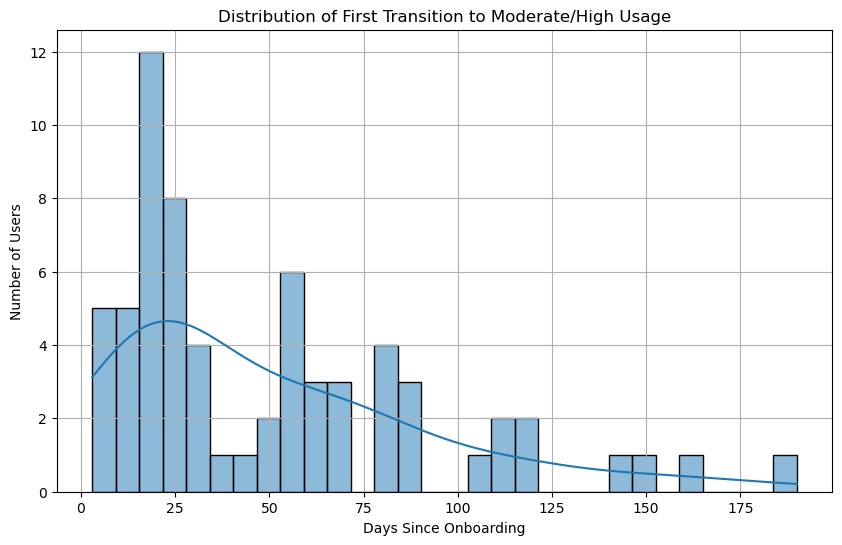

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(transition_df['first_day_to_mod_or_high'], bins=30, kde=True)
plt.title("Distribution of First Transition to Moderate/High Usage")
plt.xlabel("Days Since Onboarding")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

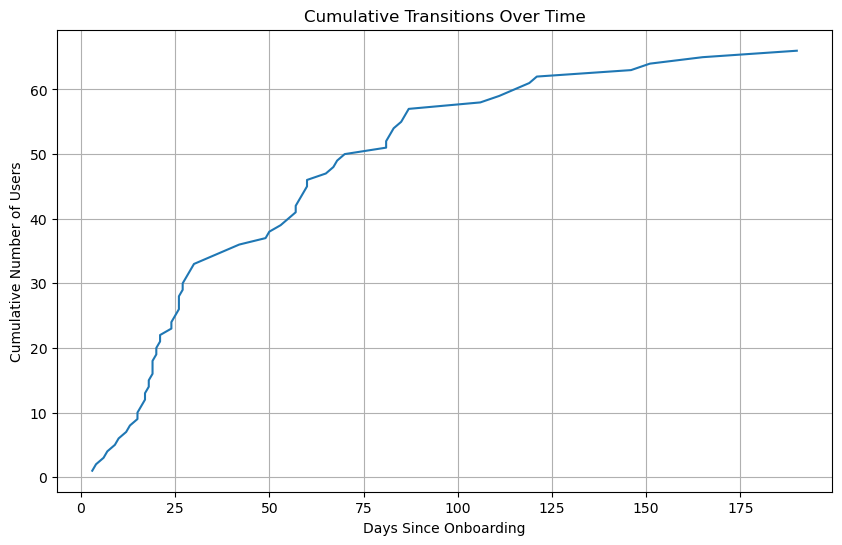

In [34]:
transition_df_sorted = transition_df.sort_values(by='first_day_to_mod_or_high')
transition_df_sorted['cumulative_users'] = range(1, len(transition_df_sorted) + 1)

plt.figure(figsize=(10, 6))
plt.plot(transition_df_sorted['first_day_to_mod_or_high'], transition_df_sorted['cumulative_users'])
plt.title("Cumulative Transitions Over Time")
plt.xlabel("Days Since Onboarding")
plt.ylabel("Cumulative Number of Users")
plt.grid(True)
plt.show()

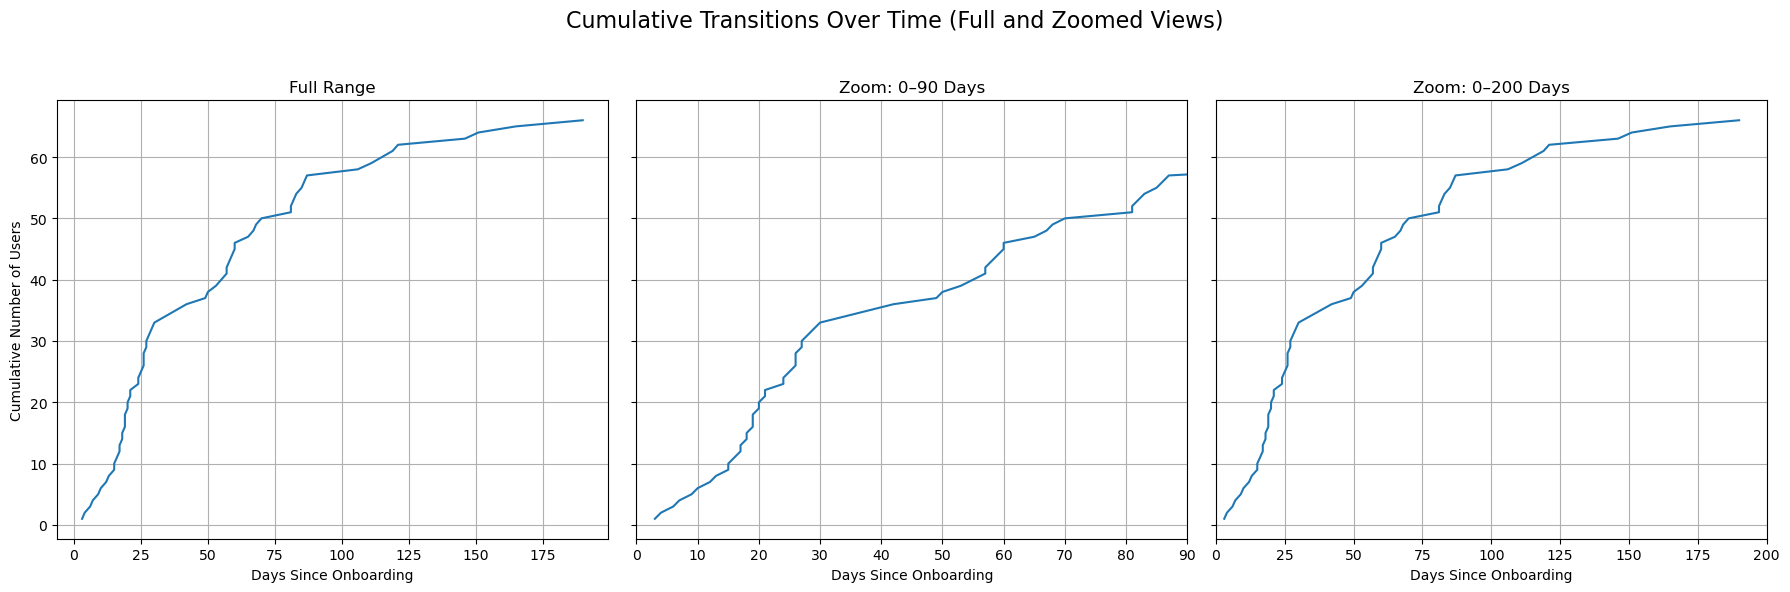

In [35]:
transition_df_sorted = transition_df.sort_values(by='first_day_to_mod_or_high')
transition_df_sorted['cumulative_users'] = range(1, len(transition_df_sorted) + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].plot(transition_df_sorted['first_day_to_mod_or_high'], transition_df_sorted['cumulative_users'])
axes[0].set_title("Full Range")
axes[0].set_xlabel("Days Since Onboarding")
axes[0].set_ylabel("Cumulative Number of Users")
axes[0].grid(True)

axes[1].plot(transition_df_sorted['first_day_to_mod_or_high'], transition_df_sorted['cumulative_users'])
axes[1].set_xlim(0, 90)
axes[1].set_title("Zoom: 0–90 Days")
axes[1].set_xlabel("Days Since Onboarding")
axes[1].grid(True)

axes[2].plot(transition_df_sorted['first_day_to_mod_or_high'], transition_df_sorted['cumulative_users'])
axes[2].set_xlim(0, 200)
axes[2].set_title("Zoom: 0–200 Days")
axes[2].set_xlabel("Days Since Onboarding")
axes[2].grid(True)

fig.suptitle("Cumulative Transitions Over Time (Full and Zoomed Views)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

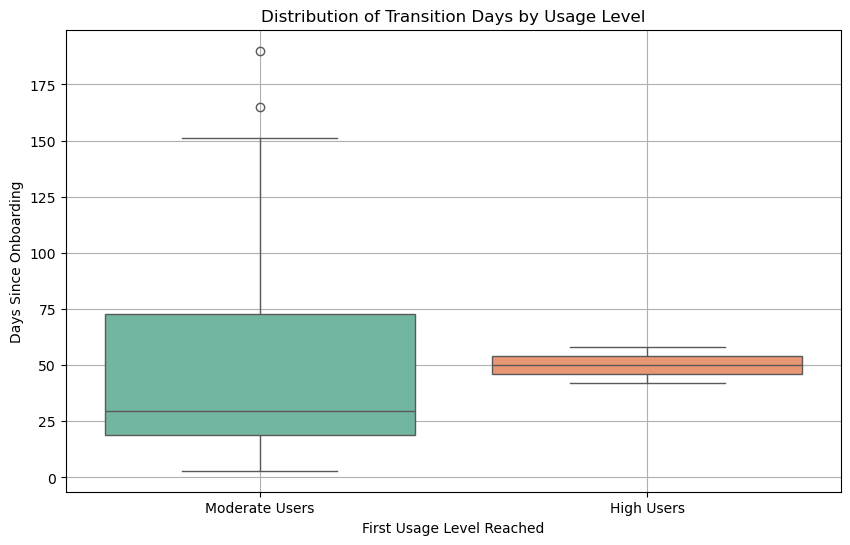

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=transition_df, x='first_level', y='first_day_to_mod_or_high', palette='Set2')
plt.title("Distribution of Transition Days by Usage Level")
plt.xlabel("First Usage Level Reached")
plt.ylabel("Days Since Onboarding")
plt.grid(True)
plt.show()

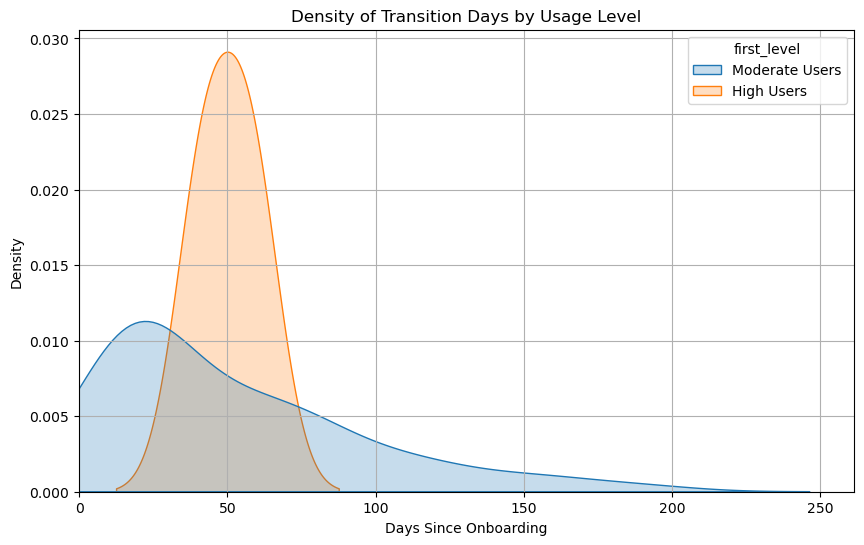

In [38]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=transition_df,
    x='first_day_to_mod_or_high',
    hue='first_level',
    fill=True,
    common_norm=False
)
plt.title("Density of Transition Days by Usage Level")
plt.xlabel("Days Since Onboarding")
plt.ylabel("Density")
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

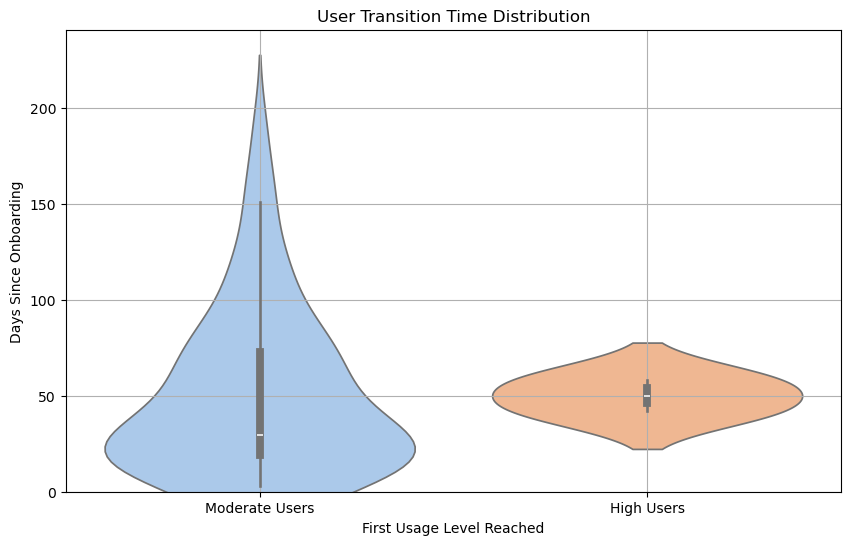

In [39]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=transition_df, x='first_level', y='first_day_to_mod_or_high', palette='pastel')
plt.title("User Transition Time Distribution")
plt.xlabel("First Usage Level Reached")
plt.ylabel("Days Since Onboarding")
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

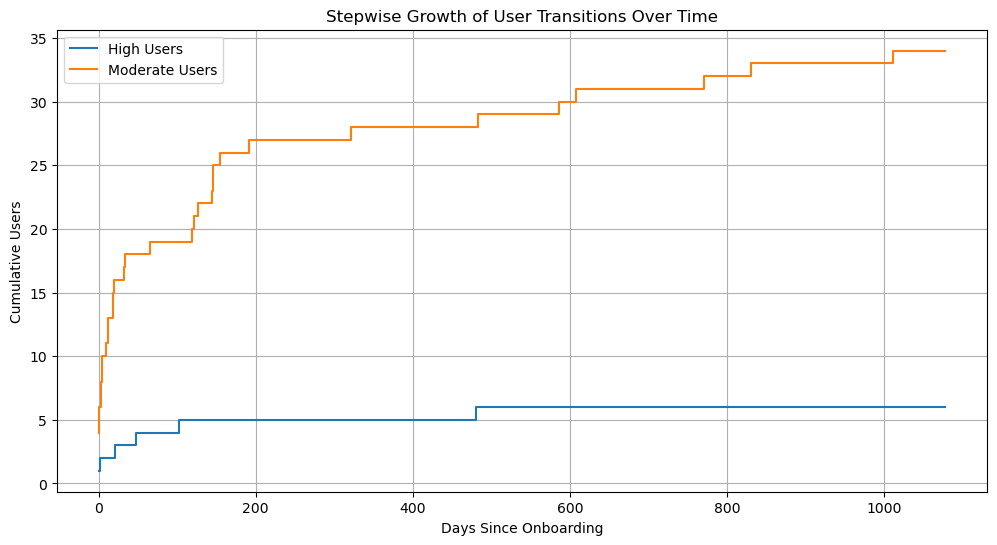

In [66]:
step_df = transition_df.groupby(['first_day_to_mod_or_high', 'first_level']).size().unstack(fill_value=0).cumsum()

plt.figure(figsize=(12, 6))
for level in step_df.columns:
    plt.step(step_df.index, step_df[level], label=level)

plt.title("Stepwise Growth of User Transitions Over Time")
plt.xlabel("Days Since Onboarding")
plt.ylabel("Cumulative Users")
plt.legend()
plt.grid(True)
plt.show()

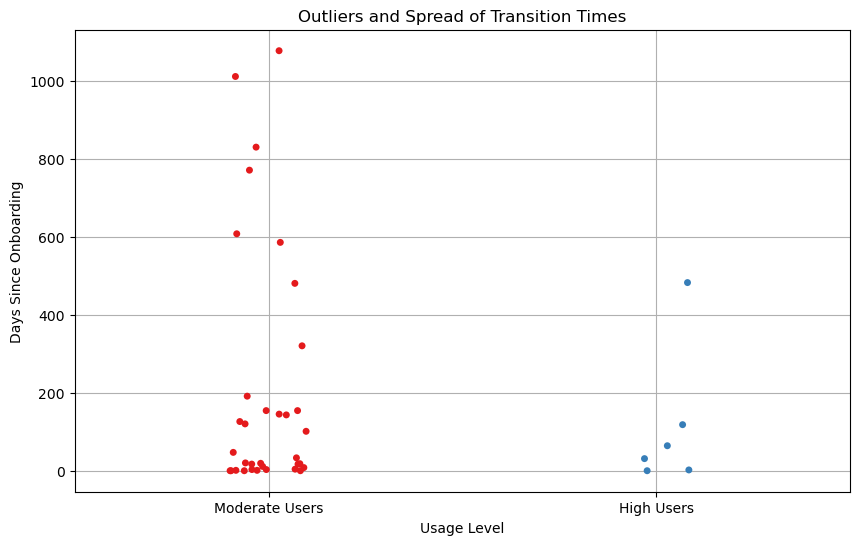

In [67]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=transition_df, x='first_level', y='first_day_to_mod_or_high', jitter=True, size=5, palette='Set1')
plt.title("Outliers and Spread of Transition Times")
plt.xlabel("Usage Level")
plt.ylabel("Days Since Onboarding")
plt.grid(True)
plt.show()

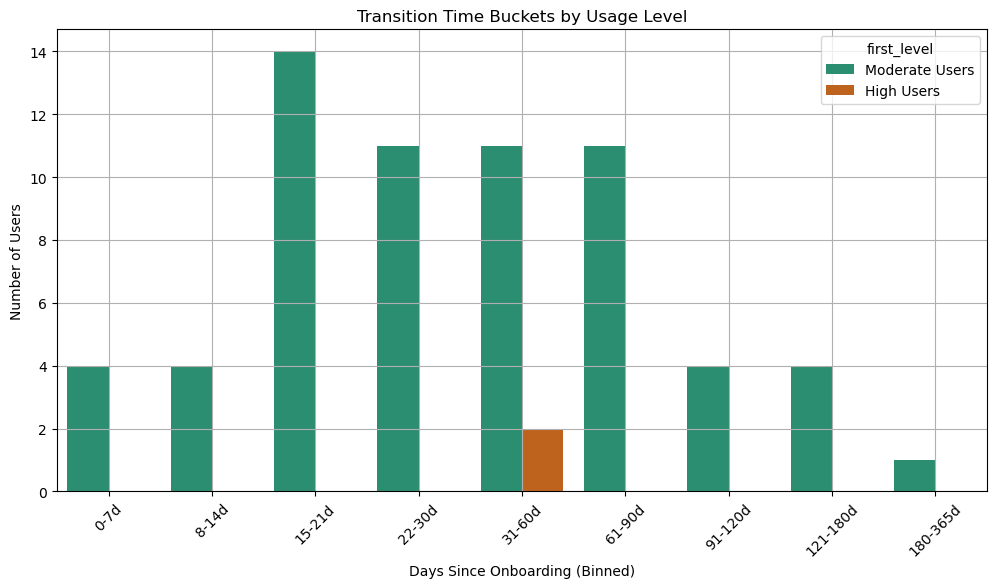

In [30]:
bins = [0, 7, 14, 21, 30, 60, 90, 120, 180, 365]
labels = ['0-7d', '8-14d', '15-21d', '22-30d', '31-60d', '61-90d', '91-120d', '121-180d', '180-365d']
transition_df['bucket'] = pd.cut(transition_df['first_day_to_mod_or_high'], bins=bins, labels=labels)

plt.figure(figsize=(12, 6))
sns.countplot(data=transition_df, x='bucket', hue='first_level', palette='Dark2')
plt.title("Transition Time Buckets by Usage Level")
plt.xlabel("Days Since Onboarding (Binned)")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

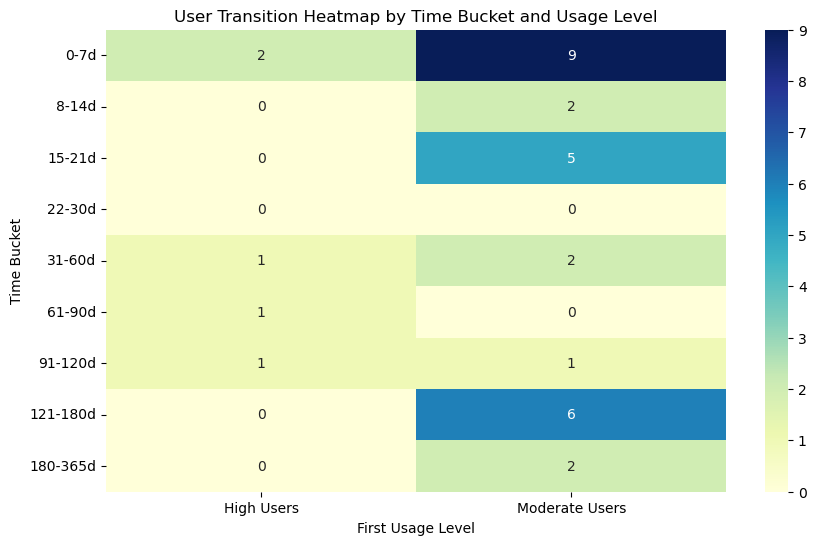

In [69]:
heat_data = transition_df.groupby(['bucket', 'first_level']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(heat_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title("User Transition Heatmap by Time Bucket and Usage Level")
plt.xlabel("First Usage Level")
plt.ylabel("Time Bucket")
plt.show()

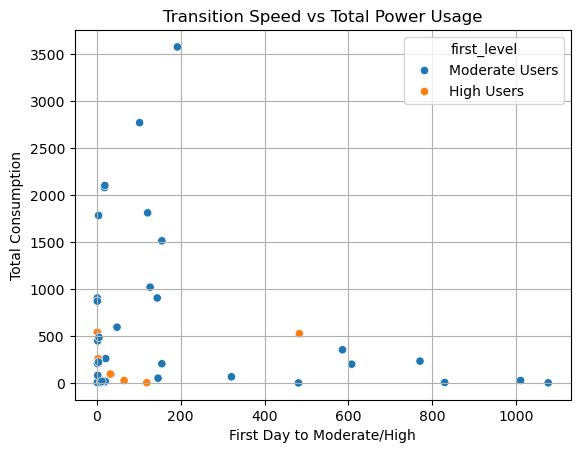

In [71]:
user_totals = df.groupby('unit_number')['daily_power_consumption'].sum().reset_index()
merged = transition_df.merge(user_totals, on='unit_number')

sns.scatterplot(data=merged, x='first_day_to_mod_or_high', y='daily_power_consumption', hue='first_level')
plt.title("Transition Speed vs Total Power Usage")
plt.xlabel("First Day to Moderate/High")
plt.ylabel("Total Consumption")
plt.grid(True)
plt.show()

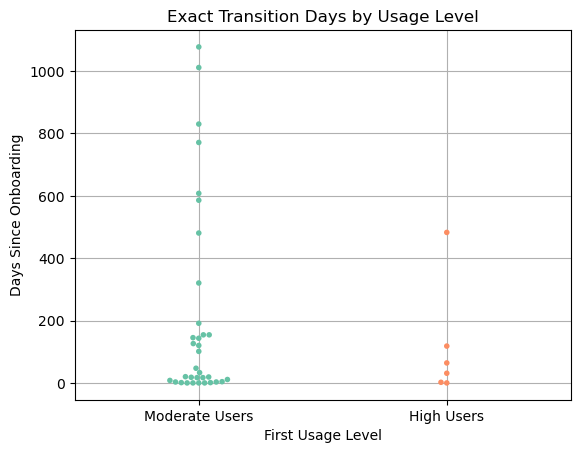

In [75]:
sns.swarmplot(data=transition_df, x='first_level', y='first_day_to_mod_or_high', palette='Set2', size=4)
plt.title("Exact Transition Days by Usage Level")
plt.xlabel("First Usage Level")
plt.ylabel("Days Since Onboarding")
plt.grid(True)
plt.show()

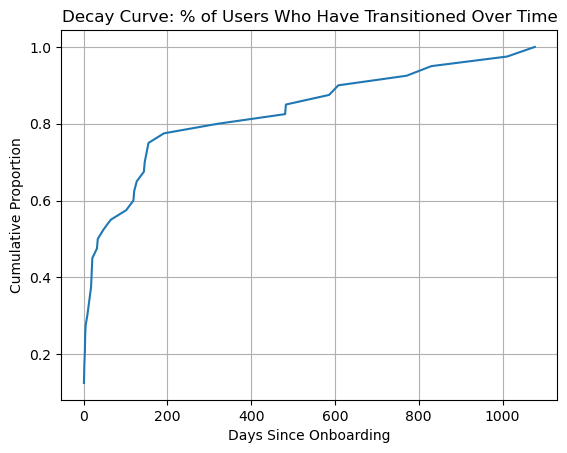

In [ ]:
decay_curve = transition_df['first_day_to_mod_or_high'].value_counts().sort_index().cumsum()
decay_curve = decay_curve / decay_curve.max()

plt.plot(decay_curve.index, decay_curve.values)
plt.title("Decay Curve: % of Users Who Have Transitioned Over Time")
plt.xlabel("Days Since Onboarding")
plt.ylabel("Cumulative Proportion")
plt.grid(True)
plt.show()

In [81]:
# Step 1: Prepare daily stats
daily_stats = df.groupby(['unit_number', 'days_since_onboarding'])['daily_power_consumption'] \
                .agg(['mean', 'std', 'max', 'min']).reset_index().fillna(0)

clustered_records = []
days = sorted(daily_stats['days_since_onboarding'].unique())
cluster_labels = ['Low Users', 'Moderate Users', 'High Users']

# Step 2: Assign clusters per day
for day in days:
    day_data = daily_stats[daily_stats['days_since_onboarding'] == day].copy()
    if len(day_data) < 3:
        continue

    scaler = StandardScaler()
    scaled = scaler.fit_transform(day_data[['mean', 'std', 'max', 'min']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    day_data['cluster'] = kmeans.fit_predict(scaled)

    centroids = day_data.groupby('cluster')['mean'].mean().sort_values().reset_index()
    labels = ['Low Users', 'Moderate Users', 'High Users']
    label_map = {}

    for i, row in centroids.iterrows():
        label_map[row['cluster']] = labels[i] if i < len(labels) else f"Cluster {row['cluster']}"


    day_data['usage_level'] = day_data['cluster'].map(label_map)
    day_data['day_str'] = day_data['days_since_onboarding'].astype(str)
    clustered_records.append(day_data[['unit_number', 'day_str', 'usage_level']])

# Step 3: Combine all records
journey_df = pd.concat(clustered_records, ignore_index=True)
journey_df = journey_df.sort_values(['unit_number', 'day_str'])

# Step 4: Calculate transitions between days
timeline_transitions = []

for i in range(len(days) - 1):
    day = days[i]
    next_day = days[i + 1]

    current_df = journey_df[journey_df['day_str'] == str(day)]
    next_df = journey_df[journey_df['day_str'] == str(next_day)]

    merged = pd.merge(current_df, next_df, on='unit_number', suffixes=('_curr', '_next'))
    transition_grp = merged.groupby(['usage_level_curr', 'usage_level_next']).size().reset_index(name='count')
    transition_grp['day_str'] = str(day)
    timeline_transitions.append(transition_grp)

# Step 5: Pivot and prepare for plotting
timeline_df = pd.concat(timeline_transitions, ignore_index=True)
pivot_df = timeline_df.pivot_table(
    index='day_str',
    columns=['usage_level_curr', 'usage_level_next'],
    values='count',
    fill_value=0
)

pivot_df.columns = [f"{frm} → {to}" for frm, to in pivot_df.columns]
# Ensure day_str is sorted numerically, not alphabetically
pivot_df.index = pivot_df.index.astype(int)
pivot_df = pivot_df.sort_index()
pivot_df.index = pivot_df.index.astype(str)  # Convert back to str for plotting


# Step 6: Reshape for Plotly
pivot_df_reset = pivot_df.reset_index().melt(
    id_vars='day_str',
    var_name='transition',
    value_name='count'
)

# Step 7: Plot interactive timeline
fig = px.area(
    pivot_df_reset,
    x='day_str',
    y='count',
    color='transition',
    title='Daily Timeline of User Transitions Between Usage Levels',
    labels={
        'day_str': 'Day Since Onboarding',
        'count': 'User Count',
        'transition': 'Transition Type'
    }
)

fig.update_layout(
    xaxis_title='Day Since Onboarding',
    yaxis_title='User Count',
    legend_title='Transition Type',
    hovermode='x unified'
)

fig.show()

In [91]:
df['quarter_block'] = ((df['days_since_onboarding'] - 1) // 90 + 1).astype(int)

quarterly_stats = df.groupby(['unit_number', 'quarter_block'])['daily_power_consumption'] \
                 .agg(['mean', 'std', 'max', 'min']).reset_index().fillna(0)

clustered_records = []
quarter_blocks = sorted(quarterly_stats['quarter_block'].unique())
cluster_labels = ['Low Users', 'Moderate Users', 'High Users']

for block in quarter_blocks:
    block_data = quarterly_stats[quarterly_stats['quarter_block'] == block].copy()
    if len(block_data) < 3:
        continue

    scaler = StandardScaler()
    scaled = scaler.fit_transform(block_data[['mean', 'std', 'max', 'min']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    block_data['cluster'] = kmeans.fit_predict(scaled)

    centroids = block_data.groupby('cluster')['mean'].mean().sort_values().reset_index()
    labels = ['Low Users', 'Moderate Users', 'High Users']
    label_map = {row['cluster']: labels[i] if i < len(labels) else f'Cluster {row["cluster"]}'
                 for i, row in centroids.iterrows()}

    block_data['usage_level'] = block_data['cluster'].map(label_map)
    block_data['quarter_str'] = 'Q' + block_data['quarter_block'].astype(str)
    clustered_records.append(block_data[['unit_number', 'quarter_block', 'quarter_str', 'usage_level']])

journey_df = pd.concat(clustered_records, ignore_index=True)
journey_df = journey_df.sort_values(['unit_number', 'quarter_block'])

timeline_transitions = []

for i in range(len(quarter_blocks) - 1):
    curr_block = quarter_blocks[i]
    next_block = quarter_blocks[i + 1]

    current_df = journey_df[journey_df['quarter_block'] == curr_block]
    next_df = journey_df[journey_df['quarter_block'] == next_block]

    merged = pd.merge(current_df, next_df, on='unit_number', suffixes=('_curr', '_next'))
    transition_grp = merged.groupby(['usage_level_curr', 'usage_level_next']) \
                           .size().reset_index(name='count')
    transition_grp['quarter_block'] = curr_block
    transition_grp['quarter_str'] = 'Q' + str(curr_block)
    timeline_transitions.append(transition_grp)

timeline_df = pd.concat(timeline_transitions, ignore_index=True)

pivot_df = timeline_df.pivot_table(
    index='quarter_block',
    columns=['usage_level_curr', 'usage_level_next'],
    values='count',
    fill_value=0
)

pivot_df.columns = [f"{frm} → {to}" for frm, to in pivot_df.columns]
pivot_df['quarter_str'] = 'Q' + pivot_df.index.astype(str)

pivot_df_reset = pivot_df.reset_index().melt(
    id_vars=['quarter_block', 'quarter_str'],
    var_name='transition',
    value_name='count'
)

transition_order = pivot_df_reset.groupby('transition')['count'].sum().sort_values(ascending=False).index.tolist()
pivot_df_reset['transition'] = pd.Categorical(
    pivot_df_reset['transition'],
    categories=transition_order,
    ordered=True
)

fig = px.area(
    pivot_df_reset.sort_values(['quarter_block', 'transition']),
    x='quarter_str',
    y='count',
    color='transition',
    title='User Transitions Between Usage Levels (Per Quarter)',
    labels={
        'quarter_str': 'Quarter Since Onboarding',
        'count': 'User Count',
        'transition': 'Transition Type'
    },
    category_orders={'transition': transition_order}
)

fig.update_layout(
    xaxis_title='Quarter Since Onboarding',
    yaxis_title='User Count',
    legend_title='Transition Type',
    hovermode='x unified'
)

fig.show()

In [42]:
df.head()

,days_since_onboarding,unit_number,registration_date_utc,calendar_date,daily_power_consumption,usage_band,week_bucket
0,1,134449719,2024-10-11,2024-10-12,0.00,Zero,0-6d
1,2,134449719,2024-10-11,2024-10-13,0.00,Zero,0-6d
2,3,134449719,2024-10-11,2024-10-14,0.00,Zero,0-6d
3,4,134449719,2024-10-11,2024-10-15,0.01,Very Low,0-6d
4,5,134449719,2024-10-11,2024-10-16,0.00,Zero,0-6d


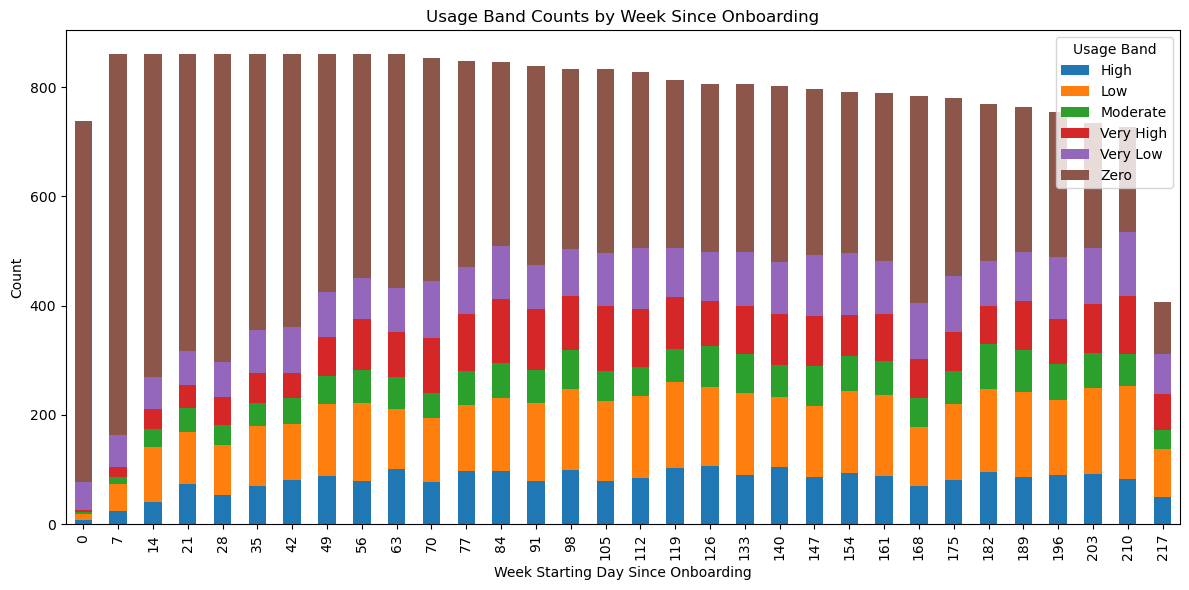

In [45]:
df['week_bucket'] = (df['days_since_onboarding'] // 7) * 7 

grouped = df.groupby(['week_bucket', 'usage_band']).size().reset_index(name='count')

pivot = grouped.pivot(index='week_bucket', columns='usage_band', values='count').fillna(0)

pivot.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Usage Band Counts by Week Since Onboarding')
plt.xlabel('Week Starting Day Since Onboarding')
plt.ylabel('Count')
plt.legend(title='Usage Band')
plt.tight_layout()
plt.show()